# Multi-Layer Perceptron, MNIST


MLP를 훈련하여 이미지 분류기를 생성해 본다. 손글씨 데이터[MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database를 사용하여 0~9를 분류하는 모형을 만든다.

다음과 같은 절차로 수행한다.:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

시작하기 위해 필요한 패키지를 import한다.

In [2]:
# import libraries
import torch
import numpy as np

---
## 1. Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

torchvision에서 제공되는 MNIST 데이터 셋을 다운로드 하여 수행한다. `batch_size`는 필요에 따라 선택할 수 있다.  
MNIST 데이터 셋을 dataloader를 생성하여 신경망의 입력 데이터로 사용한다.

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='../data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='../data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize a Batch of Training Data

모형을 구성하기 전에 읽어 들인 데이터를 확인하는 차원에서 이미지 데이터를 확인한다.  


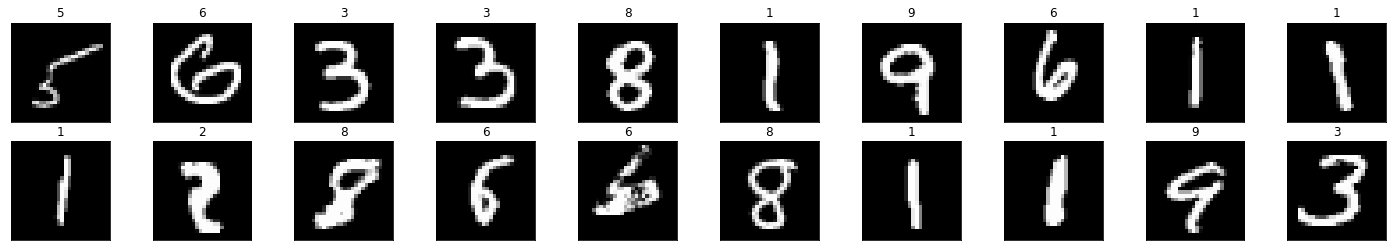

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail
개별적으로 이미지 하나를 출력해 보면 다음과 같다.

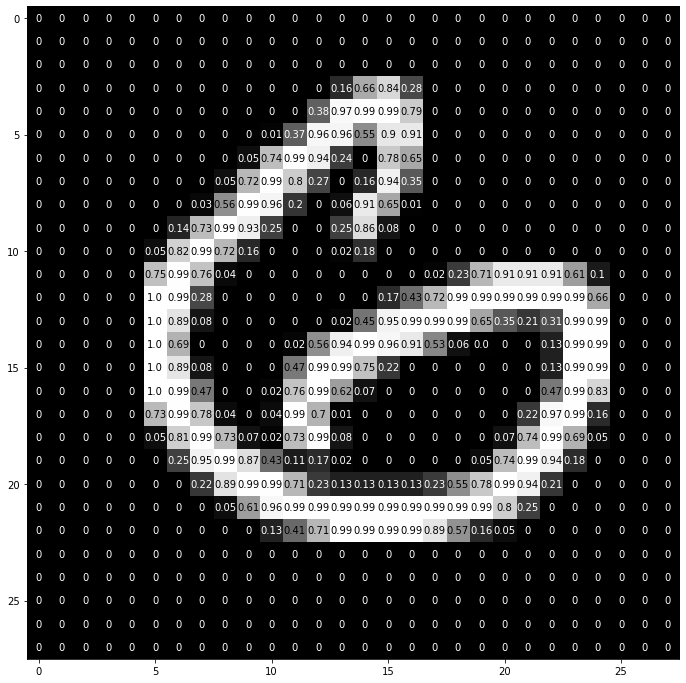

In [14]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## 2. Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

손글씨 인식을 위해 MLP(multi layer perceptron)모형을 구성한다.  
기본적인 구조는 784개(28X28)의 pixel정보를 784dim의 텐서로 읽어 들여 0~9 사이의 분류값으로 분류하는 모형을 구현하기 위한 것이다.  
- 2개의 hidden layer로 구성한다.
- overfitting을 피하기 위해 dropout을 사용한다.


In [15]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

classification을 위해서 loss 함수는 cross-entropy를 사용한다. 

In [16]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
## 3. Train the Network

각각의 batch에 대하여 다음과 같은 순서로 훈련을 진행한다.:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

epoch의 횟수는 훈련시간을 고려하여 정하도록 한다. n_epochs=10으로 하면 훈련시간은 약 6~7분 정도 소요될 것이다.  
훈련이 진행되면서 loss의 감소를 확인한다.valid loss가 가장 작은 모형을 저장한다. 

In [17]:
# number of epochs to train the model
n_epochs = 5

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        data = data.view(data.shape[0], -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        data = data.view(data.shape[0], -1)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.770864 	Validation Loss: 0.075857
Validation loss decreased (inf --> 0.075857).  Saving model ...
Epoch: 2 	Training Loss: 0.284067 	Validation Loss: 0.057067
Validation loss decreased (0.075857 --> 0.057067).  Saving model ...
Epoch: 3 	Training Loss: 0.226177 	Validation Loss: 0.047311
Validation loss decreased (0.057067 --> 0.047311).  Saving model ...
Epoch: 4 	Training Loss: 0.186837 	Validation Loss: 0.039396
Validation loss decreased (0.047311 --> 0.039396).  Saving model ...
Epoch: 5 	Training Loss: 0.159556 	Validation Loss: 0.035022
Validation loss decreased (0.039396 --> 0.035022).  Saving model ...


###  Load the Model with the Lowest Validation Loss
훈련중에 저장한 최소 valid loss를 가지는 모형을 불러들인다. 

In [18]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

---
## 4. Test the Trained Network

마지막으로 best model을 이용하여 **test data**를 사용하여 생성된 모형을 테스트한다.  
훈련에 사용되지 않은 테스트 데이터를 사용하여 모형을 평가한다. 
test loss와 accuracy로 평가할 수 있다.


In [19]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.163091

Test Accuracy of     0: 98% (963/980)
Test Accuracy of     1: 98% (1116/1135)
Test Accuracy of     2: 93% (968/1032)
Test Accuracy of     3: 96% (970/1010)
Test Accuracy of     4: 95% (937/982)
Test Accuracy of     5: 91% (815/892)
Test Accuracy of     6: 96% (922/958)
Test Accuracy of     7: 93% (960/1028)
Test Accuracy of     8: 93% (908/974)
Test Accuracy of     9: 94% (951/1009)

Test Accuracy (Overall): 95% (9510/10000)


### Visualize Sample Test Results

테스트 결과를 시각적으로 판단할 수 있다.  
해당 테스트 결과에서 `predicted (ground-truth)`형태로 예측값을 확인한다. 모형에 의한 예측값이 실제 데이터의 참값(ground-truth)를 맞추었으면 녹색 틀리면 빨간색으로 표시한다.

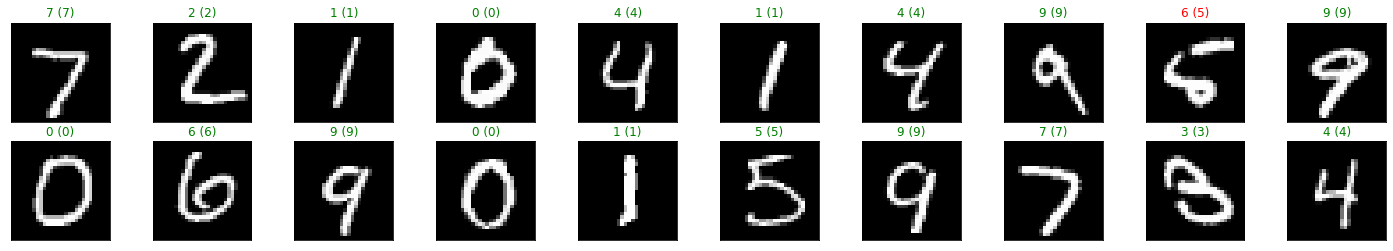

In [20]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))